## Digital-analogue variational quantum eigensolver(DAVQE)


In [1]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_nature
!pip install qutip
!pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.2 MB/s 
     |████████████████████████████████| 18.0 MB 250 kB/s 
     |████████████████████████████████| 240 kB 45.0 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 112 kB 29.1 MB/s 
     |████████████████████████████████| 943 kB 37.7 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 1.6 MB 49.6 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 4.1 MB 41.5 MB/s 
     |████████████████████████████████| 112 kB 59.3 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.1-py3-none-any.whl size=12067 sha256=c9b67d1c41463f58ca5868390b0cdcd880b574db5354417ecfa7508c193db11e
  Stored in directory: /root/.cache/pip/wheels/1c/3c/a3/bf8c2

In [2]:
from DA_VQE import *

This notebook is aimed to solve the ground state energy of the hydrogen molecule by using Digital-analogue variational quantum eigensolver(DA-VQE). In conventional VQE, entanglement of qubits is performed by the digital control gates such as CX gates.

DA-VQE, on the other hand, employs a time-evolution operator $U(t) = e^{iH't}$. $H'$ usually consists of the two-spin interactions, which is distinct from the target Hamiltonian $H$ for optimization.


First, we define the two-qubit hamiltonian $H$.

In [4]:
LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH")
print(f'Number of qubits: {LiH_op.num_qubits}')
ref_value = energy_solver(LiH_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(LiH_problem, LiH_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.545 Å


/usr/local/lib/python3.7/dist-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


Number of qubits: 4
Bonding energy value: -8.89100
Total energy: -7.86347


In [3]:
seed = 175
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,shots=8192) 

## Time-evolution operator $U(t)$
Note that this time-evolving Hamiltonian is not the Hamiltonian we want to optimize. (non-commutative with the target Hamiltonian for optimizing)<- This might be wrong!


The ground state wave function is an eigenstate of the optimizing hamiltonian with the eigenvalue $E_0$. Then, the time evolving operator $U(t) = e^{iH't}$ acting on the ground state part only gets the phase. We want, on the other hand, the hopping between the energy states so the coefficients <GS|ψ(θ)> becomes maximum.

In [5]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeff1 = h_coeffs[0]
        self.h_coeff2 = h_coeffs[1]
        self.h_coeff3 = h_coeffs[2]
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs[0], h_coeffs[1], h_coeffs[2]], label=label)
        # note that params[0] is time, params[1] is num_qubits, params[2] is connectivity
        # params[3] is h_coeff1, params[4] is h_coeff2, params[5] is h_coeff3

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)
        xx_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_x interactions
        yy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_y interactions

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        # repeat for xx and yy interaction hamiltonian. Note that we will change the params[] index    
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmax()
            xx_hamiltonian += float(self.params[4]) * np.array(qt.tensor(ops_to_tensor)) 
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmay()
            yy_hamiltonian += float(self.params[5]) * np.array(qt.tensor(ops_to_tensor)) 
            # now assemble the full hamiltonian
        hamiltonian = zz_hamiltonian + xx_hamiltonian + yy_hamiltonian    
        return hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits=len(qubits), connectivity=connectivity, h_coeffs = h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

Another option would be to create your own ansatz instead of using on of the predefined ones like TwoLocal. This is especially handy when you want to create an ansatz with analog blocks later.

In [6]:
def digital_analogue_ansatz(Operator, entanglement = "entire"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("$\phi$", 4 * n_qubits)
    
    if entanglement == "entire":
        t = Parameter("t")
        psi = ParameterVector("$\psi$",3)
        connectivity_arr = []
        qubits_arr = [0]
        for i in range(n_qubits - 1):
            connectivity_arr.append([i, i+1])
            qubits_arr.append(i+1)
    
    if entanglement == "staggered":
        psi = ParameterVector("$\psi$",3*(n_qubits - 1))
        
    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "entire":
        ansatz.custom_hamiltonian(connectivity=connectivity_arr, h_coeffs=psi, time=t , qubits=qubits_arr,label='analog block')
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], time=1, qubits=[i,i+1], label='$U_{}(t)$'.format(i))
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
        
    if entanglement == "entire":
        ansatz.bind_parameters({t: 0.3})
        ansatz.bind_parameters({psi[0]: 0.3})
        ansatz.bind_parameters({psi[1]: 0.3})
        ansatz.bind_parameters({psi[2]: 0.3})
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz

In [8]:
def find_E0(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire"):
    cirq = digital_analogue_ansatz(Operator, entanglement)
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    return result, hist

In [11]:
distances = np.arange(0.5, 3.0, 0.2)
result_entire_list = []
hist_entire_list = []
result_st_list = []
hist_st_list = []
exact_energy_list = []

for dis in distances:
  print("distance: {} started".format(dis))
  LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH", dis)
  exact_energy_list.append(total_energy_solver(LiH_problem, LiH_converter))
  result, hist = find_E0(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(20,)),SLSQP(maxiter=1000))
  result_entire_list.append(result)
  hist_entire_list.append(hist)
  result, hist = find_E0(LiH_op, np.random.uniform(low=0.5, high=2.0, size=(25,)),SLSQP(maxiter=1000),entanglement="staggered")
  result_st_list.append(result)
  hist_st_list.append(hist)

distance: 0.5 started
distance: 0.7 started
distance: 0.8999999999999999 started
distance: 1.0999999999999999 started
distance: 1.2999999999999998 started
distance: 1.4999999999999998 started
distance: 1.6999999999999997 started
distance: 1.8999999999999997 started
distance: 2.0999999999999996 started
distance: 2.3 started
distance: 2.4999999999999996 started
distance: 2.6999999999999993 started
distance: 2.8999999999999995 started


In [12]:
total_entire = []
total_st = []
for i in range(len(distances)):
  LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH", distances[i])
  vqe_result = LiH_problem.interpret(result_entire_list[i]).total_energies[0].real
  total_entire.append(vqe_result)
  vqe_result = LiH_problem.interpret(result_st_list[i]).total_energies[0].real
  total_st.append(vqe_result)

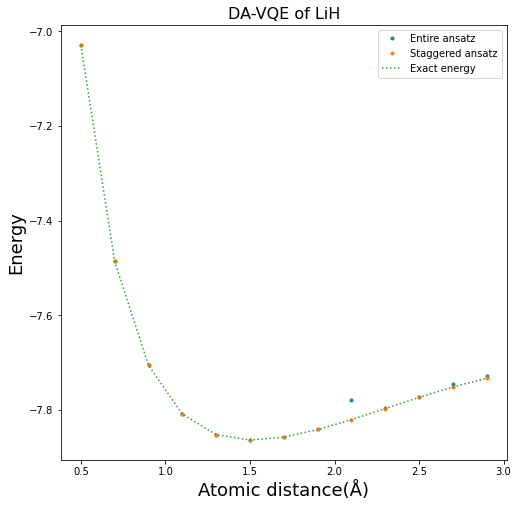

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(distances, total_entire,".",label="Entire ansatz")
plt.plot(distances, total_st,".",label="Staggered ansatz")
plt.plot(distances, exact_energy_list,":",label="Exact energy")
plt.xlabel("Atomic distance(Å)",fontsize=18)
plt.ylabel("Energy",fontsize=18)
plt.title("DA-VQE of LiH",fontsize=16)
plt.legend()